<a href="https://colab.research.google.com/github/DenCorson/LoanAmountPredictor/blob/main/Copy_of_Loan_Predicter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive') ## mounts data to google drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
training_data = pd.read_csv("gdrive/MyDrive/train_loan.csv")
test_data = pd.read_csv("gdrive/MyDrive/test_loan.csv")

In [ ]:
training_data.isnull().sum()  ## checks the total amount of missing values in training data set

,0
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14


In [ ]:
## PreProcessing Steps Below

training_data['Gender'] = training_data['Gender'].fillna('Not Known')  ##Fills in missing values under gender column with Not Known
training_data['Married'] = training_data['Married'].fillna('Not Known')  ##Fills in missing values under Married column with Not Known
training_data['Dependents'] = training_data['Dependents'].fillna(training_data['Dependents'].mode()[0])  ##Fills in missing categorical values in Dependents column with the mode of the feature
training_data['Self_Employed'] = training_data['Self_Employed'].fillna(training_data['Self_Employed'].mode()[0])  ##Fills in missing categorical values in Dependents column with the mode of the feature
training_data['LoanAmount'] = training_data['LoanAmount'].fillna(training_data['LoanAmount'].median()) ##Fills in missing Numerical values in LoanAmount column with the median of the feature
training_data['Loan_Amount_Term'] = training_data['Loan_Amount_Term'].fillna(training_data['Loan_Amount_Term'].mode()[0])  ##Fills in missing categorical values in Loan_Amount_Term column with the mode of the feature
training_data['Credit_History'] = training_data['Credit_History'].fillna(training_data['Credit_History'].mode()[0]);  ##Fills in missing categorical values in Credit_History column with the mode of the feature


In [ ]:
training_data.isnull().sum()  ## checks to see if missing values are filled in for respective columns in training set

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


In [ ]:
test_data.isnull().sum()  ## Displays the total number of missing values in each column for test set

,0
Loan_ID,0
Gender,11
Married,0
Dependents,10
Education,0
Self_Employed,23
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,5
Loan_Amount_Term,6


In [ ]:
test_data['Gender'] = test_data['Gender'].fillna('Not Known')
test_data['Dependents'] = test_data['Dependents'].fillna(test_data['Dependents'].mode()[0])
test_data['Self_Employed'] = test_data['Self_Employed'].fillna(test_data['Self_Employed'].mode()[0])
test_data['LoanAmount'] = test_data['LoanAmount'].fillna(test_data['LoanAmount'].median())
test_data['Loan_Amount_Term'] = test_data['Loan_Amount_Term'].fillna(test_data['Loan_Amount_Term'].mode()[0])
test_data['Credit_History'] = test_data['Credit_History'].fillna(test_data['Credit_History'].mode()[0]);


In [ ]:
test_data.isnull().sum()  ## checks to see if missing values are filled in for respective columns in test  set

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


In [ ]:

# Split training data into training and validation sets
training_X = training_data.drop(['Loan_ID', 'LoanAmount','Loan_Status'], axis = 1) ## drops the features 'Loan_ID, Loan_Status' as it doesnt contribute to training model, 'Loan_amount' dropped as its target feature
training_y = training_data['LoanAmount'] ## label contains only "LoanAmount" column the target variable

test_X = test_data.drop(['LoanAmount','Loan_ID'], axis = 1) ## drops target variable 'LoanAmount' column from test data,as well as Loan_ID, model will be trained by remaining features
test_Y = test_data['LoanAmount']

X_train, X_val, y_train, y_val = train_test_split(training_X, training_y, test_size=0.2, random_state=42)


categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area'] ## Gathers and stores all categorical features


## Logic Below Converts X_Train,Validation and Test_X into encoded data changing catogrical columns into individual columns, with true or false (boolean) values, of the multiple available options for feature ( ie Gender_ Female, Gender_Male, Gender unknown) for models to better recogonize and understand patterns

X_train_encoded = pd.get_dummies(X_train, columns = categorical_cols) ## One hot encodes categorical columns in X_train with stored categorical_columns
X_val_encoded = pd.get_dummies(X_val, columns = categorical_cols) ## One hot encodes categorical columns in X_val with stored categorical_columns


test_X_encoded = pd.get_dummies(test_X, columns = categorical_cols) ## One hot encodes categorical columns in test_X with stored categorical_columns


In [ ]:
## Scaler logic standardizes numerical features in dataset
X_val_encoded = X_val_encoded.reindex(columns=X_train_encoded.columns, fill_value=0) ## ensures X_val encoded columns match with test_x_encoded  both of these refernce train_encode columns after one hot encode   any missing data or columns will be filled with 0
test_X_encoded = test_X_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
scaler = StandardScaler()

## Scaled training and validation x
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

## Scaled test_x
test_X_scaled = scaler.transform(test_X_encoded)


In [ ]:
## Rule Based Approached First
def rule_based_approached(input_data):
  loan_amount = 0
 ## rule 1 determines loan amount depending on applicants amount of dependents
  if input_data['Dependents'] == '3+':
      loan_amount = 400
  elif input_data['Dependents'] == '2':
      loan_amount = 300
  elif input_data['Dependents'] == '1':
      loan_amount = 200
  else:
      loan_amount = 100
## rule 2 determines loan amount depending on applicants property location
  if input_data['Property_Area'] == 'Urban':
      loan_amount  = loan_amount + 40
  elif input_data['Property_Area'] == 'Semiurban':
      loan_amount =  loan_amount + 20
  else:
      loan_amount = loan_amount + 10

## rule 3 determines loan amount depending on applicants education level
  if input_data['Education'] == 'Graduate':
      loan_amount = loan_amount + 150
  else:
      loan_amount = loan_amount + 50

  return loan_amount

In [ ]:

# Apploes the rule-based approach fof each row on the test_X dataset  predicting the loanamount with given conditions
test_X['Predicted_LoanAmount'] = test_X.apply(rule_based_approached, axis=1)

## creates variable which will hold "Predicted_LoanAmount into an array of values from the above rule-based approached, to be compared with test_Y predicted_loanAmounts
rule_based_X = test_X['Predicted_LoanAmount'].values
# Display the DataFrame with the new predicted column

print(rule_based_X.shape) ## Displays each predicted row with rule based approach


(367,)


In [ ]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error,r2_score
print(test_Y.shape)

## Scoring metric for rule based approach
rule_based_r2_score = r2_score(test_Y, rule_based_X)
rule_based_max_error = max_error(test_Y, rule_based_X)
rule_based_mean_abs_error = mean_absolute_error(test_Y, rule_based_X)
rule_based_mean_squared_error = mean_squared_error(test_Y, rule_based_X)

print(f"r2 Score: {rule_based_r2_score:.2f}s")
print(f"Max error: {rule_based_max_error:.2f}")
print(f"Mean absolute error: {rule_based_mean_abs_error:.2f}")
print(f"Mean squared error Score: {rule_based_mean_squared_error:.2f}")

(367,)
r2 Score: -13.03s
Max error: 550.00
Mean absolute error: 198.52
Mean squared error Score: 51990.89


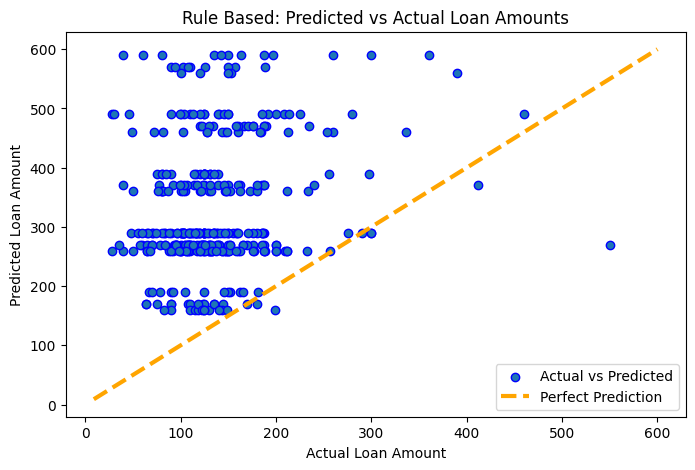

In [ ]:
## Provide scatter plot visual; of results of rulebased

# Scatter plot of actual vs predicted Loan Amounts
plt.figure(figsize=(8, 5))
plt.scatter(test_Y, rule_based_X, edgecolors="b")
y_val_min = y_val.min()
y_val_max = y_val.max()

plt.plot([y_val_min,y_val_max], [y_val_min,y_val_max],'--', color = 'orange', lw=3)
plt.xlabel('Actual Loan Amount')
plt.ylabel('Predicted Loan Amount')
plt.title('Rule Based: Predicted vs Actual Loan Amounts')
plt.legend(['Actual vs Predicted', 'Perfect Prediction'])
plt.show()


In [ ]:
## RANDOM FOREST MODEL NON-TUNED

from sklearn.ensemble import RandomForestRegressor
import time
## Random Forest Model

rf_rg = RandomForestRegressor(random_state=42)
start_time = time.time()
rf_rg.fit(X_train_scaled, y_train)
y_pred_rf = rf_rg.predict(X_val_scaled)
end_time = time.time() - start_time

rf_rg_val_r2_score = r2_score(y_val, y_pred_rf)
rf_rg_val_max_error = max_error(y_val, y_pred_rf)
rf_rg_val_mean_abs_error = mean_absolute_error(y_val, y_pred_rf)
rf_rg_val_mean_squared_error = mean_squared_error(y_val, y_pred_rf)

print(f"r2 Score: {rf_rg_val_r2_score:.2f}s")
print(f"Randomforest Regression Time: {end_time:.2f}s")
print(f"Max error: {rf_rg_val_max_error:.2f}")
print(f"Mean absolute error: {rf_rg_val_mean_abs_error:.2f}")
print(f"Mean squared error Score: {rf_rg_val_mean_squared_error:.2f}")


r2 Score: 0.27s
Randomforest Regression Time: 0.72s
Max error: 341.40
Mean absolute error: 36.79
Mean squared error Score: 3982.69


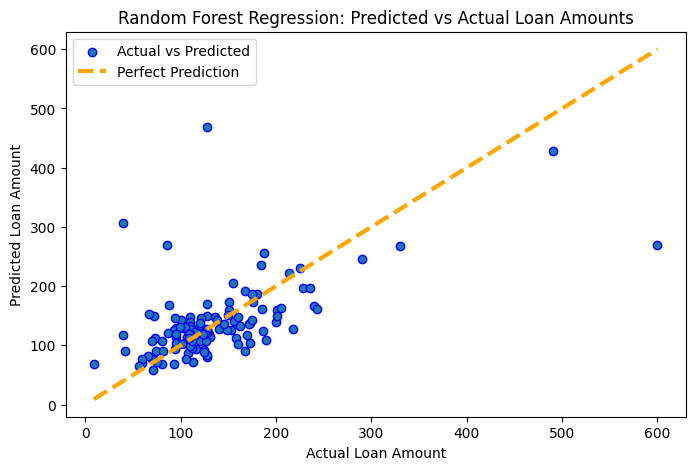

In [ ]:
## Provide scatter plot visual; of results of rf regression

# Scatter plot of actual vs predicted Loan Amounts
plt.figure(figsize=(8, 5))
plt.scatter(y_val, y_pred_rf, edgecolors="b")
y_val_min = y_val.min()
y_val_max = y_val.max()

plt.plot([y_val_min,y_val_max], [y_val_min,y_val_max],'--', color = 'orange', lw=3)
plt.xlabel('Actual Loan Amount')
plt.ylabel('Predicted Loan Amount')
plt.title('Random Forest Regression: Predicted vs Actual Loan Amounts')
plt.legend(['Actual vs Predicted', 'Perfect Prediction'])
plt.show()


In [ ]:
  ## Tunes parameters for Randforest abd retrieves best estimator from results
from sklearn.model_selection import GridSearchCV
param_grid = {
    "n_estimators": [5,6,7, 8, 9, 10, 11, 12,13, 15], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4],
    "max_features": [5, 8, 10]
}

grid_search = GridSearchCV(rf_rg, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(X_train_scaled, y_train)

grid_search.best_estimator_
print(grid_search.best_params_)


# Returns n_estimators=200 & max_features=10
best_forest_model = grid_search.best_estimator_
best_forest_model.score(X_val_scaled, y_val)

{'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 5}


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


0.45264798236013004

In [ ]:
## Tests test data for Randomforest with tuned parameters to see improvement
y_pred_test = best_forest_model.predict(test_X_scaled)

rf_mse_test = mean_squared_error(test_Y, y_pred_test)
rf_max_error_test = max_error(test_Y, y_pred_test)
rf_mean_abs_error_test = mean_absolute_error(test_Y, y_pred_test)
rf_r2_score_test = r2_score(test_Y, y_pred_test)


print(f"r2 Score: {rf_r2_score_test:.2f}s")
print(f"Randomforest Time: {end_time:.2f}s")
print(f"Max error: {rf_max_error_test:.2f}")
print(f"Mean absolute error: {rf_mean_abs_error_test:.2f}")
print(f"Mean squared error Score: {rf_mse_test:.2f}")

r2 Score: 0.31s
Randomforest Time: 0.72s
Max error: 234.07
Mean absolute error: 35.63
Mean squared error Score: 2558.22


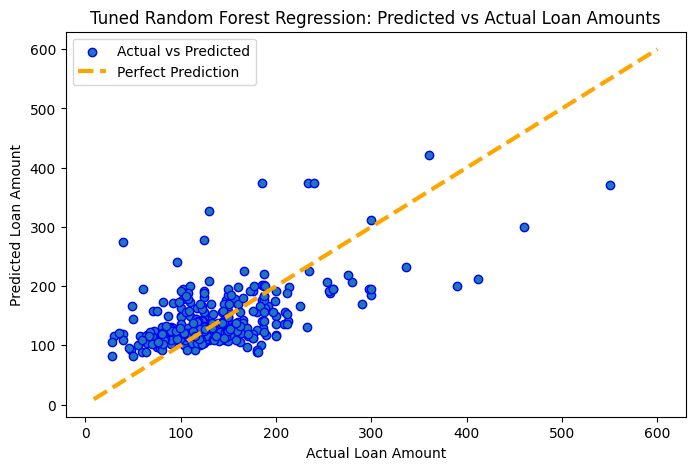

In [ ]:
## Test visualization of the Tuned,best estimator Random Forest
## Provide scatter plot visual; of results of rf regression

# Scatter plot of actual vs predicted Loan Amounts
plt.figure(figsize=(8, 5))
plt.scatter(test_Y, y_pred_test, edgecolors="b")
y_val_min = y_val.min()
y_val_max = y_val.max()

plt.plot([y_val_min,y_val_max], [y_val_min,y_val_max],'--', color = 'orange', lw=3)
plt.xlabel('Actual Loan Amount')
plt.ylabel('Predicted Loan Amount')
plt.title('Tuned Random Forest Regression: Predicted vs Actual Loan Amounts')
plt.legend(['Actual vs Predicted', 'Perfect Prediction'])
plt.show()


In [ ]:
## GRADIENT BOOST MODEL (NON TUNED)

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error,r2_score
import time
## Gradient Boost Model

gbm = GradientBoostingRegressor(random_state=100)
start_time = time.time()
gbm.fit(X_train_scaled, y_train)
y_pred_gbm = gbm.predict(X_val_scaled)
end_time = time.time() - start_time

gbm_val_r2_score = r2_score(y_val, y_pred_gbm)
gbm_val_max_error = max_error(y_val, y_pred_gbm)
gbm_val_mean_abs_error = mean_absolute_error(y_val, y_pred_gbm)
gbm_val_mean_squared_error = mean_squared_error(y_val, y_pred_gbm)

print(f"r2 Score: {gbm_val_r2_score:.2f}s")
print(f"gbm Regression Time: {end_time:.2f}s")
print(f"Max error: {gbm_val_max_error:.2f}")
print(f"Mean absolute error: {gbm_val_mean_abs_error:.2f}")
print(f"Mean squared error Score: {gbm_val_mean_squared_error:.2f}")


r2 Score: 0.48s
gbm Regression Time: 0.19s
Max error: 314.37
Mean absolute error: 33.31
Mean squared error Score: 2828.28


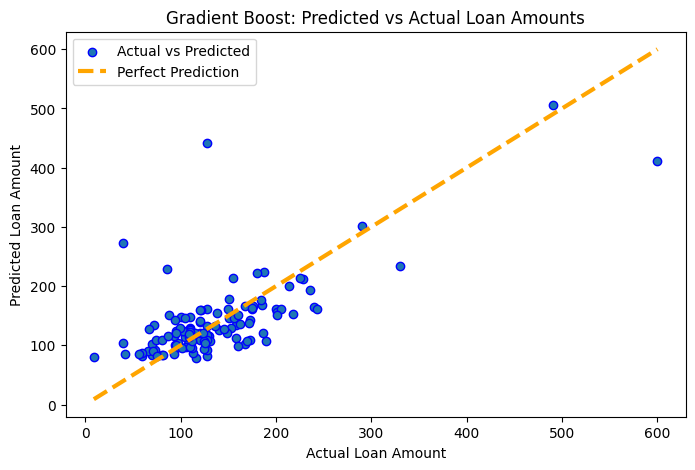

In [ ]:
## Provide scatter plot visual; of results of rf regression

# Scatter plot of actual vs predicted Loan Amounts
plt.figure(figsize=(8, 5))
plt.scatter(y_val, y_pred_gbm, edgecolors="b")
y_val_min = y_val.min()
y_val_max = y_val.max()

plt.plot([y_val_min,y_val_max], [y_val_min,y_val_max],'--', color = 'orange', lw=3)
plt.xlabel('Actual Loan Amount')
plt.ylabel('Predicted Loan Amount')
plt.title('Gradient Boost: Predicted vs Actual Loan Amounts')
plt.legend(['Actual vs Predicted', 'Perfect Prediction'])
plt.show()



In [ ]:
  ## Tune parameters for GBM abd retrieves best estimator from results
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

grid_search = GridSearchCV(gbm, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(X_train_scaled, y_train)

grid_search.best_estimator_
print(grid_search.best_params_)


# Returns n_estimators=200 & max_features=10
best_GBM_model = grid_search.best_estimator_
best_GBM_model.score(X_val_scaled, y_val)

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}


0.39552755239730164

In [ ]:
## Tests test data for GBM  with tuned parameters to see improvement
y_pred_test = best_GBM_model.predict(test_X_scaled)

gbm_mse_test = mean_squared_error(test_Y, y_pred_test)
gbm_max_error_test = max_error(test_Y, y_pred_test)
gbm_mean_abs_error_test = mean_absolute_error(test_Y, y_pred_test)
gbm_r2_score_test = r2_score(test_Y, y_pred_test)


print(f"r2 Score: {gbm_r2_score_test:.2f}s")
print(f"gbm Regression Time: {end_time:.2f}s")
print(f"Max error: {gbm_max_error_test:.2f}")
print(f"Mean absolute error: {gbm_mean_abs_error_test:.2f}")
print(f"Mean squared error Score: {gbm_mse_test:.2f}")

r2 Score: 0.32s
gbm Regression Time: 0.19s
Max error: 330.41
Mean absolute error: 33.70
Mean squared error Score: 2523.63


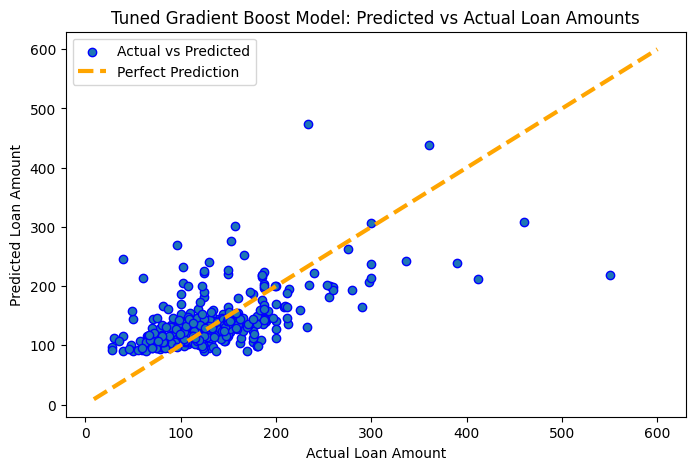

In [ ]:
## Test visualization of the Tuned,best estimator Gradient Boost
## Provide scatter plot visual; of results of Gradient Boost

# Scatter plot of actual vs predicted Loan Amounts
plt.figure(figsize=(8, 5))
plt.scatter(test_Y, y_pred_test, edgecolors="b")
y_val_min = y_val.min()
y_val_max = y_val.max()

plt.plot([y_val_min,y_val_max], [y_val_min,y_val_max],'--', color = 'orange', lw=3)
plt.xlabel('Actual Loan Amount')
plt.ylabel('Predicted Loan Amount')
plt.title('Tuned Gradient Boost Model: Predicted vs Actual Loan Amounts')
plt.legend(['Actual vs Predicted', 'Perfect Prediction'])
plt.show()

In [ ]:
## LogisticRegression Model (NON TUNED)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error,r2_score
import time
## LogisticRegression

logRegress = LogisticRegression(random_state=100)
start_time = time.time()
logRegress.fit(X_train_scaled, y_train)
y_pred_logRegress = logRegress.predict(X_val_scaled)
end_time = time.time() - start_time

logRegress_val_r2_score = r2_score(y_val, y_pred_rf)
logRegress_val_max_error = max_error(y_val, y_pred_rf)
logRegress_val_mean_abs_error = mean_absolute_error(y_val, y_pred_rf)
logRegress_val_mean_squared_error = mean_squared_error(y_val, y_pred_rf)

print(f"r2 Score: {logRegress_val_r2_score:.2f}s")
print(f"Linear Regression Time: {end_time:.2f}s")
print(f"Max error: {logRegress_val_max_error:.2f}")
print(f"Mean absolute error: {logRegress_val_mean_abs_error:.2f}")
print(f"Mean squared error Score: {logRegress_val_mean_squared_error:.2f}")


r2 Score: 0.27s
Linear Regression Time: 0.24s
Max error: 341.40
Mean absolute error: 36.79
Mean squared error Score: 3982.69


In [ ]:
## SVR  MODEL

from sklearn.svm import SVR
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error,r2_score
import time
## SVR

svr = SVR(kernel = 'rbf')
start_time = time.time()
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_val_scaled)
end_time = time.time() - start_time

svr_val_r2_score = r2_score(y_val, y_pred_svr)
svr_val_max_error = max_error(y_val, y_pred_svr)
svr_val_mean_abs_error = mean_absolute_error(y_val, y_pred_svr)
svr_val_mean_squared_error = mean_squared_error(y_val, y_pred_svr)

print(f"r2 Score: {svr_val_r2_score:.2f}s")
print(f"SVR  Time: {end_time:.2f}s")
print(f"Max error: {svr_val_max_error:.2f}")
print(f"Mean absolute error: {svr_val_mean_abs_error:.2f}")
print(f"Mean squared error Score: {svr_val_mean_squared_error:.2f}")


r2 Score: 0.02s
SVR  Time: 0.07s
Max errory: 468.46
Mean absolute error: 44.60
Mean squared error Score: 5335.01
